In [1]:
import numpy as np
import matplotlib as plt
import os 
import timeit
from scipy.stats import uniform
from numba import jit

Define help function to compute the total stiffness

In [165]:
@jit(nopython=True)  # Use nopython mode for best performance
def compute_stiffness(w, th , E , l1 , l2 , oe): 
    """
    Inputs:
    w - Beam width
    th - Beam thickness 
    E - Young's modulus of the beam material
    l1 - Length of the longer beams
    l2 - Length of the shorter beams
    oe - Overetch affecting the effective width of the beam

     Output:
     kTotal - Total stiffness of the folded beam structure
    """
    effectiveWidth = w - 2*oe
    J = (1/12) * th * effectiveWidth**3
    #Stiffness of individual beams based on their length
    k1 = 12 * E * J / (l1**3 * 4)
    k2 = 12 * E * J / (l2**3 * 2)
    kTotal = 2 / (1/k1 + 1/k2)
    
    return kTotal


In [166]:
@jit(nopython=True)  # Use nopython mode for best performance
def fringing_coeff( G, W ,L):
    return (1+ G/np.pi/W + G/np.pi/W*np.log(2*np.pi*W/G))*(1+ G/np.pi/L + G/np.pi/L*np.log(2*np.pi*L/G))
    
    

In [174]:
@jit(nopython=True)  # Use nopython mode for best performance
def coarse_model(params):
    """
    - Inputs:
    - parameters[0] : Overetch 
    - parameters[1] : Offset
    - parameters[2] : Thickness

    - Output:
    - C : An array containing the computed difference of capacitance 
    """
    # Time parameters
    t0 = 0                    # Initial time.
    tf = 0.0015-1e-5          # Final time.
    dt = 1e-5                  # Time step size.

    # Stiffness parameters
    l1 = 221.4*1e-6              # Lenght of the longer beam 
    l2 = 110*1e-6            # Length of the shorted beam
    E  = 160*1e9               # Young Modulus 
    w  = 2.8*1e-6              # Width 

    # Force parameters 
    phi = lambda t: 0.9*(1-np.cos(2*np.pi*2500*t)) if t < 2/2500 else 0 # Voltage in the right electrodes
    
    s   = 101*1e-6             # param for the surface 
    dp  =1.2*1e-6                # Distance from the plates with Overetch and Offset = 0 

    # Mass parameters
    rho = 2320                 # Density of the mass.
    A   = 84*1e-9              # Area of the component

    # Damping parameters 
    alpha = 31440            # Damping coefficient alpha. 31400
    beta  =  0               # Damping coeff beta 

    # Input Parameters 
    oe = params[0]*1e-6
    of = params[1]*1e-6
    th = params[2]*1e-6 # ricorda di rimettere 6
   
    eps0 = 8.854*1e-12       # Dielectric permittivity constant
    eps1 = 1.000             # Relative dielectric permittivity of air.

    # Compute the distance between the faces of electrodes and the sensor
    dl = dp+2*oe+of
    dr = dp+2*oe-of
    # Compute the surface of the electrode 
    S = th * (s - 2*oe) * 10  # multiply by ten since we have 10 condensators
    
    # Initial conditions
    u0 = 0  # Initial displacement
    v0 = 0  # Initial velocity
    N = int((tf - t0) / dt)

    # Initialization
    u = np.zeros((N+1))  # displacement
    v = np.zeros((N+1))  # velocity
    C = np.zeros((N+1))  # capacitance
    u[0] = u0
    v[0] = v0
    C[0] = eps1*eps0*S*(1/(dr)*fringing_coeff( dr, s-2*oe ,th) - 1/(dl)*fringing_coeff( dl, s-2*oe ,th))

    # Compute the stiffness
    k = compute_stiffness(w, th , E , l1 , l2 , oe) 
   
    # Compute mass
    m = rho * A * th
    # Compute Damping 
    damp = alpha* m + beta* k

    # Precompute phi values to avoid redundant computation
    k1 =  0.5 * eps0 * eps1 * S
    k2 = eps1*eps0*S
    F_values = np.array([phi(n * dt) for n in range(N)])**2 * k1

    # Time-stepping loop using Forward Euler scheme
    for n in range(N) :
        u_n = u[n]
        v_n = v[n]
        u_new = u_n + dt * v_n
        # Compute the value of the input voltage at time t = n*dt 
        F = F_values[n]/((dr-u_n)**2)
        v[n+1] = v_n + dt * ( F - damp*v_n - k*u_n )/m
        # Compute the difference of capacitance
        C[n+1] = k2*(1/(dr-u_new)*fringing_coeff( dr-u_new, s-2*oe ,th) - 1/(dl+u_new)*fringing_coeff( dl+u_new, s-2*oe ,th))
        u[n+1] = u_new

    return C*1e15*1.02

# Compare the model with the exact solutions

Select the true samples on which we want to test the corse model

In [175]:
# Standard library imports
import sys
# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
data_processor_I = preprocessing(CONFIGURATION_I)

# Extract test data 
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test

# Which sample of the training set do wou want to take as experimental input?
sample = [5,11, 22, 38, 154]

# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
print('        Overetch,   Offset,   Thickness')
x_true


        Overetch,   Offset,   Thickness


array([[ 2.3053600e-01, -6.8871000e-02,  3.0351452e+01],
       [ 4.5057900e-01, -4.4200000e-04,  2.9471304e+01],
       [ 1.5078200e-01, -6.1468000e-02,  3.0962383e+01],
       [ 2.6249600e-01, -2.7814000e-02,  2.9626475e+01],
       [ 4.8182800e-01, -4.7104400e-01,  2.9200776e+01]])

Perform comparisons with different types of inputs of parameters 

The parameters used are: [ 0.230536 -0.068871 30.351452]


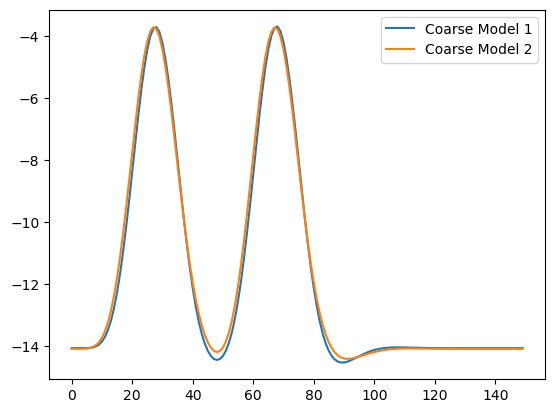

The parameters used are: [ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]


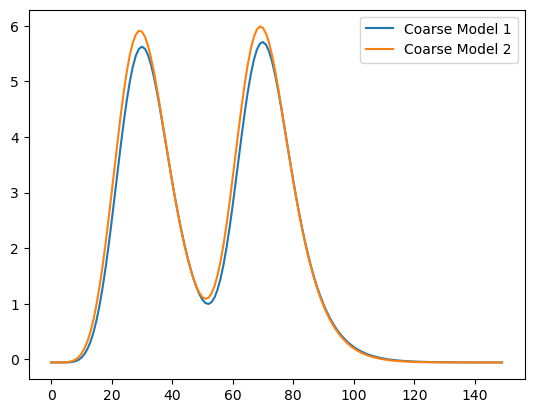

The parameters used are: [ 0.150782 -0.061468 30.962383]


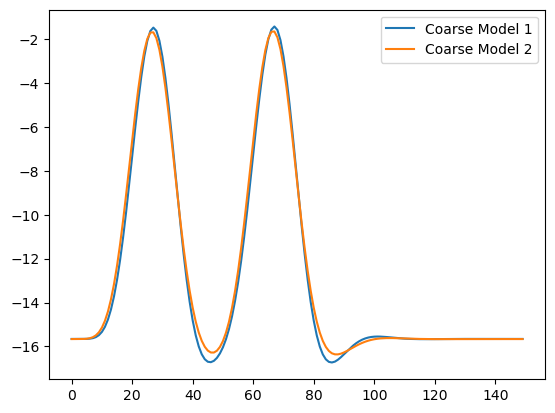

The parameters used are: [ 2.6249600e-01 -2.7814000e-02  2.9626475e+01]


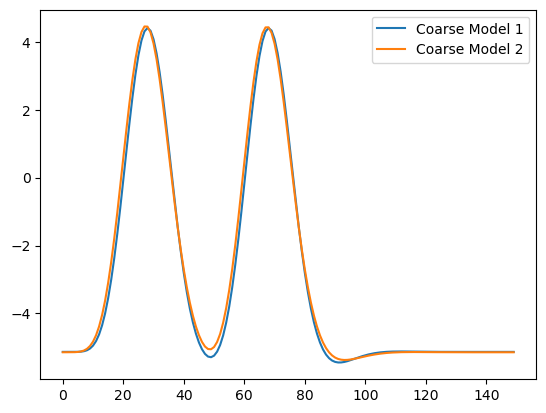

The parameters used are: [ 0.481828 -0.471044 29.200776]


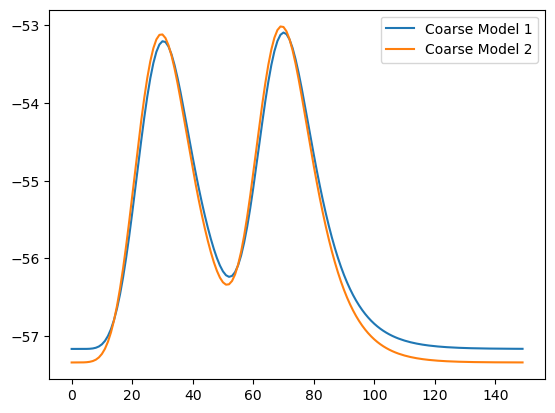

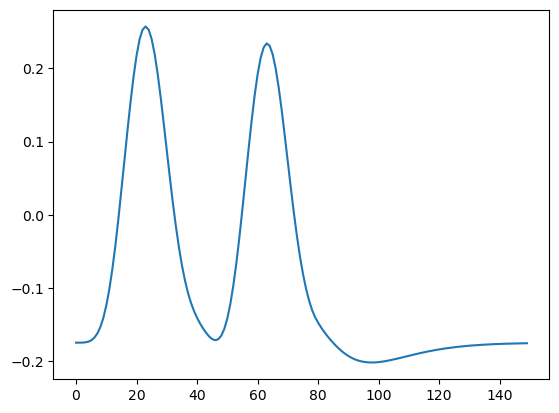

Mean absolute percentage error for the simulations are:
 [0.01478697 0.06420755 0.01865394 0.03882397 0.00280598]


In [176]:
ratio = []
for index, x in enumerate(x_true):
    print('The parameters used are:' , x)
    res = coarse_model(x) 
    
    plt.plot(res)

    plt.plot(y_true[index])
    plt.legend(['Coarse Model 1', 'Coarse Model 2','Fine Model 3'])
    plt.show()
    # print(res[0])
    ratio.append(  np.linalg.norm((res - y_true[index]), ord=1)  / np.linalg.norm(( y_true[index]), ord=1) )
''
plt.plot(y_true[-1]-res)
plt.show()
print('Mean absolute percentage error for the simulations are:\n', np.array(ratio) ) 
    

# Compare Coarse and Fine model 


Load fine model 

In [ ]:
# Initialize and load model
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])

# Define forward function
forward_model = create_forward_model_function(data_processor_I, model_I)

Compare fine and coarse model on the paramters x

In [ ]:
# Define parameters x
X = np.random.uniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]), size=[1000,3])
# RMB: lower_bound= [0.1, -0.5, 29.0],  upper_bound=[0.5, 0.5, 31.0]

start_time = timeit.default_timer()
res_coarse = [coarse_model(X[i,:]) for i in range(1000)]  
end_time = timeit.default_timer()

res_fine = [forward_model(X[i,:]) for i in range(1000)] 
end_time2 = timeit.default_timer()

print('Time Coarse', end_time-start_time)
print('Time fine', end_time2-end_time)




2024-05-03 16:12:16.427142: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Time Coarse 0.7028954170000006
Time fine 16.783857958000002


# Multilevel NN 

Let us now train a simplified NN compared to the fine models that takes as input parameter the output of the coarse model

First we have to create a dataset of the coarse sol for all the data we have 

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [ ]:
# Collecting traing and Testing Data
X_train = data_processor_I.X_train
X_test = data_processor_I.X_test
y_train = data_processor_I.y_train
y_test = data_processor_I.y_test

In [ ]:
coarse_y_train = []
coarse_y_test = []
for x in X_train:  
    coarse_y_train.append(coarse_model(x))
for x in X_test:
    coarse_y_test.append(coarse_model(x))

# Concatenate input parameters and coarse solutions
X_train_combined = np.concatenate((X_train, coarse_y_train), axis=1)
X_test_combined = np.concatenate((X_test, coarse_y_test), axis=1)


Now we can train the NN

In [ ]:
Training = True

num_samples = 640
num_parameters = 3
num_coarse_values = 150

# Define the neural network model
model_LF_NN = Sequential([
       Dense(156, input_shape=(num_parameters + num_coarse_values,), activation='tanh'),  # First hidden layer with 32 neurons
    Dense(num_coarse_values)  # Output layer with 150 neurons (coarse solution)
])

if Training: 
   

     # Define the optimizer with an initial learning rate
    initial_learning_rate = 1e-3
    optimizer = Adam(learning_rate=initial_learning_rate)

    # Compile the model with the optimizer
    model_LF_NN.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define a learning rate scheduler
    learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train the model
    model_LF_NN.fit(X_train_combined, y_train, epochs = 2000, batch_size=32, validation_data= (X_test_combined, y_test), callbacks=learning_rate_scheduler)

    model_LF_NN.save('./models/model_LF_NN.keras')

# Load the model
model_LF_NN = load_model('./models/model_LF_NN.keras')


Epoch 1/2000
20/20 [==============================] - 0s 3ms/step - loss: 3191.2446 - val_loss: 3612.0579 - lr: 0.0010
Epoch 2/2000
20/20 [==============================] - 0s 1ms/step - loss: 2927.3835 - val_loss: 3331.5493 - lr: 0.0010
Epoch 3/2000
20/20 [==============================] - 0s 1ms/step - loss: 2677.6353 - val_loss: 3071.0581 - lr: 0.0010
Epoch 4/2000
20/20 [==============================] - 0s 1ms/step - loss: 2452.2607 - val_loss: 2833.2734 - lr: 0.0010
Epoch 5/2000
20/20 [==============================] - 0s 1ms/step - loss: 2246.0122 - val_loss: 2620.4907 - lr: 0.0010
Epoch 6/2000
20/20 [==============================] - 0s 1ms/step - loss: 2062.0781 - val_loss: 2425.3169 - lr: 0.0010
Epoch 7/2000
20/20 [==============================] - 0s 2ms/step - loss: 1898.6306 - val_loss: 2245.1655 - lr: 0.0010
Epoch 8/2000
20/20 [==============================] - 0s 1ms/step - loss: 1745.1689 - val_loss: 2090.0913 - lr: 0.0010
Epoch 9/2000
20/20 [============================

The parameters used are: [ 0.230536 -0.068871 30.351452]
(150,) (3,)


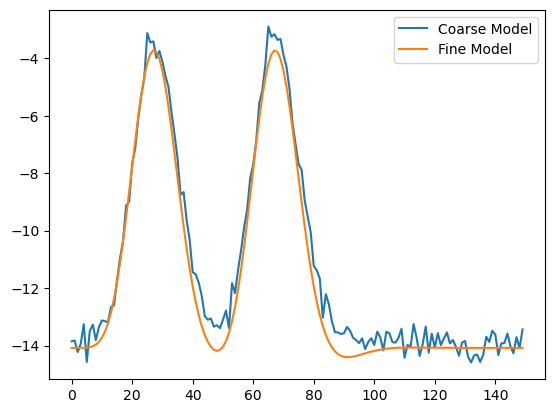

The parameters used are: [ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]
(150,) (3,)


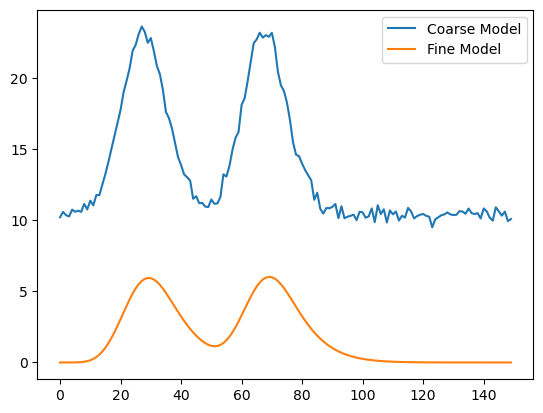

The parameters used are: [ 0.150782 -0.061468 30.962383]
(150,) (3,)


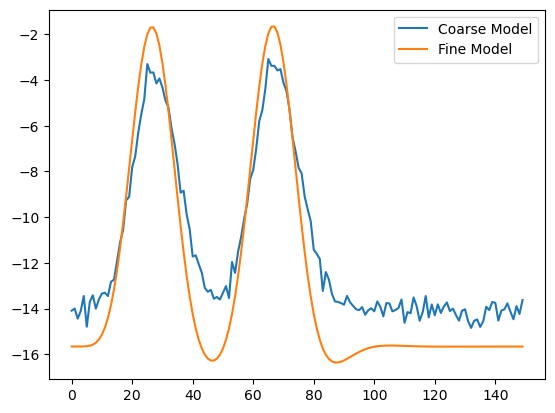

The parameters used are: [ 2.6249600e-01 -2.7814000e-02  2.9626475e+01]
(150,) (3,)


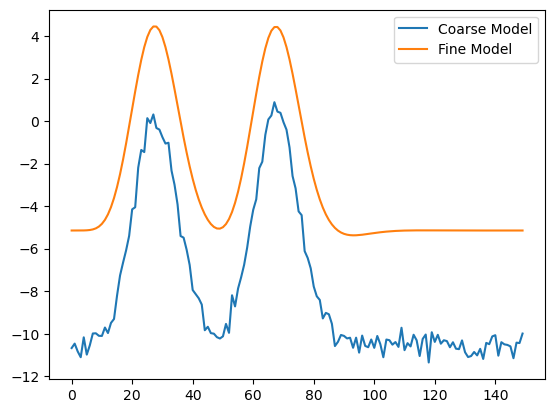

The parameters used are: [ 0.481828 -0.471044 29.200776]
(150,) (3,)


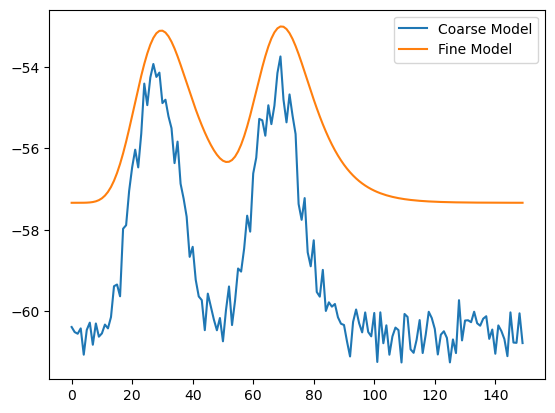

In [ ]:
ratio = []
for index, x in enumerate(x_true):
    print('The parameters used are:' , x)
    rec_c = coarse_model(x)
    np.concatenate((x, coarse_model(x)))
    print(rec_c.shape, x.shape)
    res = model_LF_NN.predict( np.concatenate((x, coarse_model(x))).reshape(1,153)).reshape(150,)
    plt.plot(res)
    plt.plot(y_true[index])
    plt.legend(['Coarse Model', 'Fine Model'])
    plt.show()

In [ ]:
# Define parameters x
X = np.random.uniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]), size=[1000,3])
# RMB: lower_bound= [0.1, -0.5, 29.0],  upper_bound=[0.5, 0.5, 31.0]

start_time = timeit.default_timer()
res_coarse = [model_LF_NN.predict( np.concatenate((X[i,:], coarse_model(X[i,:]))).reshape(1,153), verbose = False) for i in range(1000)]  
end_time = timeit.default_timer()

res_fine = [forward_model(X[i,:]) for i in range(1000)] 
end_time2 = timeit.default_timer()

print('Time Coarse', end_time-start_time)
print('Time fine', end_time2-end_time)


Time Coarse 37.06116974999895
Time fine 39.943864041997585


#### Single layer NN 

Let us now try a different type of NN 
In this case we usa a single layer NN initializing the weights as zero for the parameters and the eye matrix for the coarse solution, we also use the lineat activation function  

In [ ]:
Training = False

num_samples = 640
num_parameters = 3
num_coarse_values = 150

# Define the initial weighsts matrix 
weight_matrix = [ np.vstack([np.zeros((3,150))*0.1, np.eye(150)] ), np.zeros(150) ]

# Define the neural network model
model_LF_NN2 = Sequential([
        Dense(150,input_shape=(num_parameters + num_coarse_values,),activation='linear')
       ])

# Set the initial weights for the dense layer
model_LF_NN2.layers[0].set_weights(weight_matrix)

if Training: 
       
       # Define the optimizer with an initial learning rate
       initial_learning_rate = 1e-3
       optimizer = Adam(learning_rate=initial_learning_rate) 

       # Compile the model with the optimizer
       model_LF_NN2.compile(optimizer=optimizer, loss='mean_squared_error')

       # Define a learning rate scheduler
       learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100, min_lr=1e-6)

       # Concatenate input parameters and coarse solutions
       X_train_combined = np.concatenate((X_train, coarse_y_train), axis=1)
       X_test_combined = np.concatenate((X_test, coarse_y_test), axis=1)
    

       # Train the model
       model_LF_NN2.fit(X_train_combined, y_train, epochs = 10000, batch_size=32, validation_data= (X_test_combined, y_test), callbacks=learning_rate_scheduler)

       model_LF_NN2.save('./models/model_LF_NN2.keras')


# Load the model
model_LF_NN2 = load_model('./models/model_LF_NN2.keras')


In [ ]:
print(model_LF_NN2.layers[0].get_weights()[0][0])
print(model_LF_NN2.layers[0].get_weights()[0][1].mean())
print(model_LF_NN2.layers[0].get_weights()[0][2].mean())
# print(model_LF_NN2.layers[0].get_weights()[0][4])

[-0.46482685 -0.4653135  -0.46599045 -0.46695533 -0.47337437 -0.47166982
 -0.48006457 -0.48943368 -0.5027703  -0.52542293 -0.54672426 -0.57537466
 -0.6127812  -0.6353576  -0.6590814  -0.664502   -0.6563816  -0.6324202
 -0.5875799  -0.5139785  -0.4244037  -0.33199936 -0.24358563 -0.18288656
 -0.14854881 -0.15478994 -0.20645596 -0.28409567 -0.36664075 -0.437756
 -0.4706028  -0.46375775 -0.4094494  -0.32740942 -0.22225991 -0.12100255
 -0.03770714  0.02554504  0.06935282  0.05699452  0.01980952 -0.04047623
 -0.1153301  -0.203057   -0.3006961  -0.36906078 -0.54002243 -0.6314082
 -0.7301167  -0.8064082  -0.8740028  -0.92641574 -0.97701454 -1.0071886
 -1.020537   -1.0158404  -0.98964846 -0.9378713  -0.85153407 -0.7569181
 -0.64697474 -0.5360765  -0.42877573 -0.33291247 -0.28791824 -0.2783796
 -0.30433425 -0.36693195 -0.4432001  -0.49357748 -0.51467705 -0.49671927
 -0.44160375 -0.348514   -0.24766524 -0.14134964 -0.05641302  0.03863061
  0.05441897  0.04177143  0.00583399 -0.05445352 -0.130524

The parameters used are: [ 0.230536 -0.068871 30.351452]
(150,) (3,)


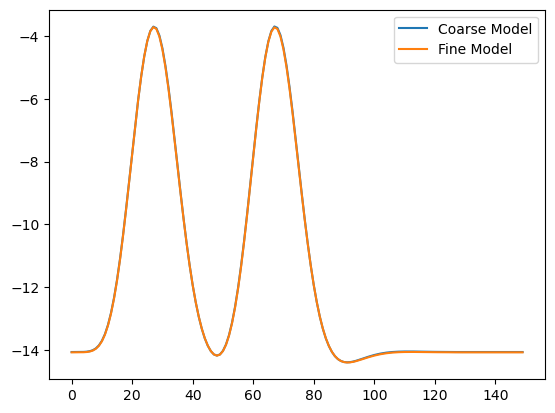

The parameters used are: [ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]
(150,) (3,)


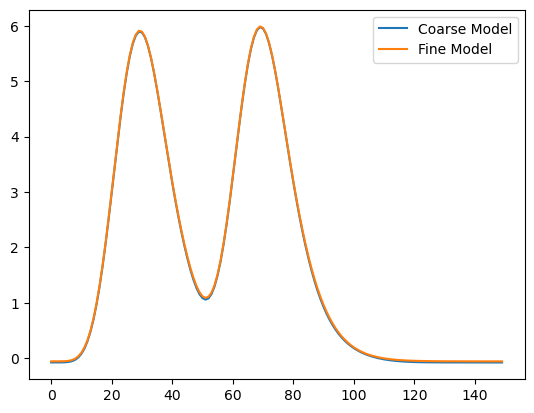

The parameters used are: [ 0.150782 -0.061468 30.962383]
(150,) (3,)


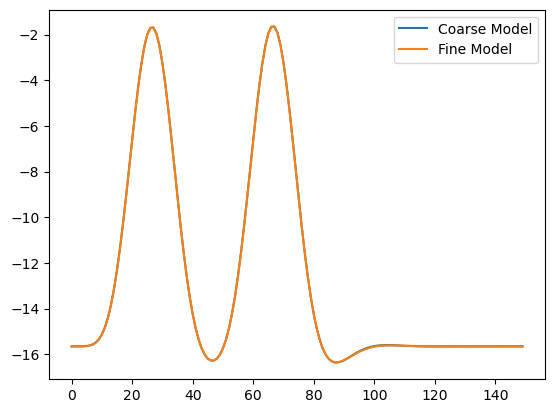

The parameters used are: [ 2.6249600e-01 -2.7814000e-02  2.9626475e+01]
(150,) (3,)


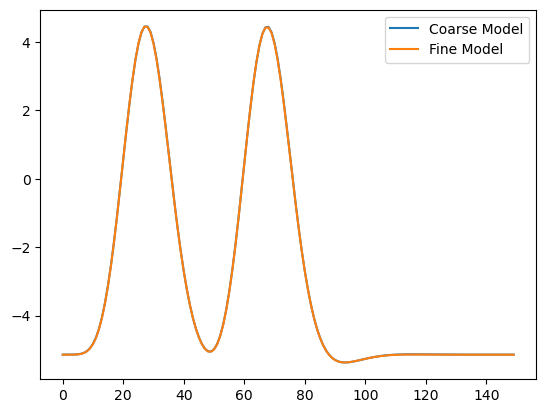

The parameters used are: [ 0.481828 -0.471044 29.200776]
(150,) (3,)


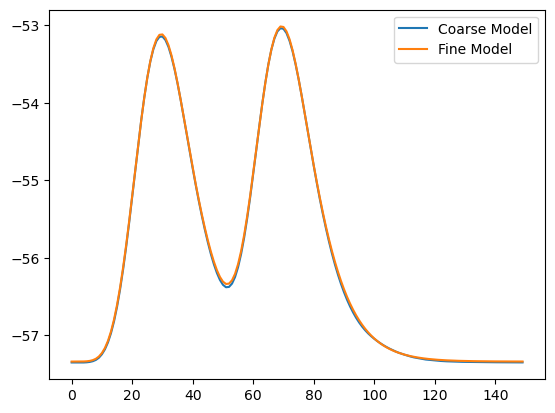

In [ ]:
ratio = []
for index, x in enumerate(x_true):
    print('The parameters used are:' , x)
    rec_c = coarse_model(x)
    np.concatenate((x, coarse_model(x)))
    print(rec_c.shape, x.shape)
    res = model_LF_NN2.predict( np.concatenate((x, coarse_model(x))).reshape(1,153)).reshape(150,)
    plt.plot(res)
    plt.plot(y_true[index])
    #plt.plot(weight_matrix*np.concatenate((x, coarse_model(x))).T)
    plt.legend(['Coarse Model', 'Fine Model', 'only_coarse'])
    plt.show()

Evaluate the speed of the new model compared to the fine one 

In [ ]:
# Define parameters x
X = np.random.uniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]), size=[1000,3])

start_time = timeit.default_timer()
#a = [np.concatenate((X[i,:], coarse_model(X[i,:]))) for i in range(1000)]  
res_coarse = [model_LF_NN2( np.concatenate((X_train[i,:], coarse_model(X_train[i,:]))).reshape(1,153)).numpy() for i in range(X_train.shape[0])]  

end_time = timeit.default_timer()

print('Time Coarse', end_time-start_time)

print(data_processor_I.X_train_scaled.shape)

res_fine = [model_I.model(np.array([data_processor_I.X_train_scaled[i,:]])).numpy() for i in range(data_processor_I.X_train_scaled.shape[0])]  

end_time2 = timeit.default_timer()

print('Time fine', end_time2-end_time)

Time Coarse 0.5433398750001288
(96000, 4)


KeyboardInterrupt: 

In [178]:
import numpy as np
import tensorflow as tf
import timeit

N = int(1e5)

# Define parameters x more efficiently
X_train = np.random.uniform(low=[0.1, -0.5, 29.0], high=[0.5, 0.5, 31.0], size=(N, 3))

time = data_processor_I.time
X_rep = np.repeat(X, len(time), axis=0)
time_repeated = np.tile(time, len(X_rep) // len(time))
X_rep = np.column_stack((X_rep, time_repeated))
X_new = data_processor_I.scaler.transform(X_rep)

# Assuming coarse_model is a TensorFlow/Keras model
# Compute the coarse model predictions in a batch
start_0 = timeit.default_timer() 
coarse_predictions = [coarse_model(X_train[i,:]) for i in range(N)]
end_0 = timeit.default_timer()

# Concatenate the input and the predictions along the last axis
concatenated_input = np.concatenate([X_train, coarse_predictions], axis=1)

# Measure time for coarse model predictions
start_time = timeit.default_timer()

# Use the model to predict in one go rather than in a loop
res_coarse = [model_LF_NN2(np.array([concatenated_input[i,:]])).numpy() for i in range(N)]

end_time = timeit.default_timer()

# Directly use the preprocessed and scaled data
start_time2 = timeit.default_timer()

res_fine = [model_I.model(X_new[150*i:150*i+150,:]).numpy() for i in range(N)]

end_time2 = timeit.default_timer()

print('Time Euler', (end_0-start_0)/N)
print('Time Coarse', (end_time - start_time)/N)
print('Time Fine', (end_time2 - start_time2)/N)


Time Euler 1.0480617499997607e-05
Time Coarse 0.00013463428375000148
Time Fine 0.000525828774169986
